In [2]:
# 1. Mount your Drive (you’ve already done this)
from google.colab import drive
drive.mount('/content/drive')

# 2. Clone your GitHub repo into Drive
!git clone https://github.com/woo13sd/rupture-theory.git "/content/drive/My Drive/rupture-theory"

# 3. Switch into that folder
%cd "/content/drive/My Drive/rupture-theory"

# 4. (Optional) Inspect Drive to find where your CAMB files live
!find "/content/drive/My Drive" -maxdepth 2 -type f -name "*.ini" -o -name "*.f90" -o -name "Rupture.ipynb"

# 5. Create the target subfolders and copy files in
!mkdir -p notebooks camb_utils

# — replace the paths below with the ones you saw in step 4 —
!cp "/content/drive/My Drive/path/to/Rupture.ipynb" notebooks/
!cp "/content/drive/My Drive/path/to/params_camb.ini" camb_utils/
!cp "/content/drive/My Drive/path/to/initialpower.f90" camb_utils/
!cp "/content/drive/My Drive/path/to/reionization.f90" camb_utils/

# 6. Stage, commit, and push
!git add notebooks/ camb_utils/
!git commit -m "Add Rupture.ipynb and CAMB support files from Drive"
!git push origin main


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cloning into '/content/drive/My Drive/rupture-theory'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.
/content/drive/My Drive/rupture-theory
/content/drive/My Drive/Colab Notebooks/Rupture.ipynb
cp: cannot stat '/content/drive/My Drive/path/to/Rupture.ipynb': No such file or directory
cp: cannot stat '/content/drive/My Drive/path/to/params_camb.ini': No such file or directory
cp: cannot stat '/content/drive/My Drive/path/to/initialpower.f90': No such file or directory
cp: cannot stat '/content/drive/My Drive/path/to/reionization.f90': No such file or directory
Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

t

In [3]:
!git config --global user.name "Robert C Woodbyrne"
!git config --global user.email "woo13sd@gmail.com"


In [ ]:
# change into the cloned repo
%cd "/content/drive/My Drive/rupture-theory"

# make folders
!mkdir -p notebooks camb_utils

# copy with your real paths—for example, if find told you:
# /content/drive/My Drive/Colab Notebooks/Rupture.ipynb
!cp "/content/drive/My Drive/Colab Notebooks/Rupture.ipynb" notebooks/

# and say you found your .ini/.f90 in /content/drive/My Drive/CAMB Files/
!cp "/content/drive/My Drive/Cosmology/CAMB/params_camb.ini"   camb_utils/
!cp "/content/drive/My Drive/CAMB Files/initialpower.f90"  camb_utils/
!cp "/content/drive/My Drive/CAMB Files/reionization.f90"  camb_utils/

# stage & commit
!git add notebooks/ camb_utils/
!git commit -m "Add Rupture.ipynb and CAMB support files"

# push back to GitHub
# Option A: use a GitHub Personal Access Token stored in an env var (safer):
import os
token = os.environ.get("GITHUB_PAT")
!git push https://{token}@github.com/woo13sd/rupture-theory.git HEAD:main

# Option B: use Colab’s built-in “Save a copy in GitHub…” from the File menu for just the notebook.


In [ ]:
!pip install camb classy --quiet


In [ ]:
# Install CAMB (retry until network allows it)
!pip install camb --quiet

import numpy as np
import camb


In [ ]:
# Uninstall any existing camb, then pull in the master branch
!pip uninstall -y camb
!pip install --upgrade git+https://github.com/cmbant/CAMB@master --quiet


Found existing installation: camb 1.6.2
Uninstalling camb-1.6.2:
  Successfully uninstalled camb-1.6.2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install camb --quiet
import numpy as np, camb


In [ ]:
import numpy as np

# Skip the header row:
data = np.loadtxt('primordial_power.dat', skiprows=1)
ks, Pks = data[:,0], data[:,1]


In [ ]:
import os
print("CWD =", os.getcwd())
print("Contents of CWD:", os.listdir('.'))


CWD = /content
Contents of CWD: ['.config', 'data', 'images', 'sample_data']


In [ ]:
import numpy as np

# Rupture‐theory feature parameters
As, ns, k0    = 2.1e-9, 0.965, 0.05
kc, alpha, σ = 0.002, 0.05, 0.3

# Build the k-grid and spectrum
k       = np.logspace(-4, 1, 200)                        # [1/Mpc]
P0      = As * (k/k0)**(ns - 1)                          # baseline power law
feature = 1 + alpha * np.exp(-0.5*(np.log(k/kc)/σ)**2)   # Gaussian bump
P_PRC   = P0 * feature                                   # rupture spectrum

# Save with a commented header
np.savetxt(
    'primordial_power.dat',
    np.column_stack([k, P_PRC]),
    header='k [1/Mpc]    P(k)',
    comments='# '
)
print("✅ primordial_power.dat written")


✅ primordial_power.dat written


In [ ]:
# Regenerate the primordial_power.dat with commented header
np.savetxt('primordial_power.dat',
           np.column_stack([k, P_PRC]),
           header='k [1/Mpc]    P(k)',
           comments='# ')


In [ ]:
data = np.loadtxt('primordial_power.dat')
ks, Pks = data[:,0], data[:,1]


In [ ]:
import numpy as np

# RT feature parameters
As, ns, k0    = 2.1e-9, 0.965, 0.05
kc, α, σ      = 0.002, 0.05, 0.3

k       = np.logspace(-4, 1, 200)
P0      = As*(k/k0)**(ns-1)
feature = 1 + α*np.exp(-0.5*(np.log(k/kc)/σ)**2)
P_PRC   = P0*feature

np.savetxt('primordial_power.dat',
           np.column_stack([k,P_PRC]),
           header='# k [1/Mpc]    P(k)')


In [ ]:
params.InitPower.set_params(As=2.1e-9, ns=0.96, nrun=-0.01)


class: <InitialPowerLaw>
 tensor_parameterization = tensor_param_rpivot
 ns = 0.96
 nrun = -0.01
 nrunrun = 0.0
 nt = -0.0
 ntrun = -0.0
 r = 0.0
 pivot_scalar = 0.05
 pivot_tensor = 0.05
 As = 2.1e-09
 At = 1.0
 

In [ ]:
import numpy as np, camb, os

# 1) Generate LCDM_EE.dat
H0, ombh2, omch2, mnu, tau = 67.36, 0.02237, 0.1200, 0.06, 0.0544
As, ns = 2.10e-9, 0.965

params = camb.CAMBparams()
params.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=mnu, tau=tau)
params.InitPower.set_params(As=As, ns=ns)
params.set_for_lmax(2500, lens_potential_accuracy=1)
params.set_matter_power(redshifts=[0.], kmax=2.0)
res = camb.get_results(params)

ells = np.arange(2501)
ee_lcdm = res.get_cmb_power_spectra(params, lmax=2500)['total'][:,1]

# Write to data/ directory
os.makedirs('data', exist_ok=True)
np.savetxt('data/LCDM_EE.dat',
           np.column_stack([ells, ee_lcdm]),
           header='ell  C_ell(EE) - LCDM baseline',
           comments='# ')
print("✅ Generated data/LCDM_EE.dat")


✅ Generated data/LCDM_EE.dat


In [ ]:
# 1) Install & import
!pip install camb --quiet
import numpy as np, camb

# 2) Parameters
H0, ombh2, omch2, mnu = 67.36, 0.02237, 0.1200, 0.06
A0, ns               = 2.10e-9, 0.965
nrun_lcdm, nrun_rupture = 0.0, 0.02
tau = 0.0544

# 3) Helper to run CAMB and return k, P(k)
def run_matter(A0, ns, nrun, tau):
    p = camb.CAMBparams()
    p.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=mnu, tau=tau)
    p.InitPower.set_params(As=A0, ns=ns, nrun=nrun)
    p.set_for_lmax(2500, lens_potential_accuracy=1)
    p.set_matter_power(redshifts=[0.], kmax=2.0)
    results = camb.get_results(p)
    # Unpack k array, z array, and Pk array
    k_array, z_array, Pk_array = results.get_matter_power_spectrum(npoints=200)
    # Take the z=0 layer
    Pk0 = Pk_array[0]
    return k_array, Pk0

# 4) Run both cases
kh_lcdm,   pk_lcdm   = run_matter(A0, ns, nrun_lcdm,   tau)
kh_rupture, pk_rupture = run_matter(A0, ns, nrun_rupture, tau)

# 5) Save to files
np.savetxt('LCDM_Pk.dat',
           np.column_stack([kh_lcdm, pk_lcdm]),
           header='k [h/Mpc]  P(k) - ΛCDM baseline')
np.savetxt('Rupture_Pk.dat',
           np.column_stack([kh_rupture, pk_rupture]),
           header='k [h/Mpc]  P(k) - Rupture-Theory approx.')

print("✅ Successfully saved matter power files:")
print("   • LCDM_Pk.dat")
print("   • Rupture_Pk.dat")


✅ Successfully saved matter power files:
   • LCDM_Pk.dat
   • Rupture_Pk.dat


In [ ]:
!pip install camb --quiet
import numpy as np

As, ns, k0 = 2.1e-9, 0.965, 0.05

k_vals = np.logspace(-4, 1, 200)
P_lcdm = As * (k_vals / k0)**(ns - 1)
np.savetxt('primordial_power_lcdm.dat',
           np.column_stack([k_vals, P_lcdm]),
           header='k [1/Mpc]    P(k) - LCDM primordial', comments='# ')
print("✅ primordial_power_lcdm.dat written")


✅ primordial_power_lcdm.dat written


In [ ]:
import numpy as np, camb

# Parameters (same as before)
As, ns, k0 = 2.1e-9, 0.965, 0.05
H0, ombh2, omch2, mnu, tau = 67.36, 0.02237, 0.1200, 0.06, 0.0544
nrun_lcdm, nrun_rupture = 0.0, 0.02

def run_camb_spectra(nrun):
    params = camb.CAMBparams()
    params.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=mnu, tau=tau)
    params.InitPower.set_params(As=As, ns=ns, nrun=nrun)
    params.set_for_lmax(2500, lens_potential_accuracy=1)
    params.set_matter_power(redshifts=[0.], kmax=2.0)
    results = camb.get_results(params)

    # CMB TT/EE
    cls = results.get_cmb_power_spectra(params, lmax=2500)['total']
    tt  = cls[:,0]
    ee  = cls[:,1]

    # Lensing potential (no dict indexing)
    clpp = results.get_lens_potential_cls(lmax=2500)

    return tt, ee, clpp

# Run LCDM
tt_lcdm, ee_lcdm, clpp_lcdm = run_camb_spectra(nrun_lcdm)
ells = np.arange(len(tt_lcdm))
np.savetxt('LCDM_Clpp.dat',
           np.column_stack([ells, clpp_lcdm]),
           header='ell  C_ell^phi phi - LCDM', comments='# ')
print("✅ LCDM_Clpp.dat written")

# Run Rupture-Theory approx
tt_rt, ee_rt, clpp_rt = run_camb_spectra(nrun_rupture)
ells = np.arange(len(tt_rt))

np.savetxt('Rupture_CAMB_TT.dat',
           np.column_stack([ells, tt_rt]),
           header='ell  C_ell(TT) - Rupture-Theory', comments='# ')
np.savetxt('Rupture_CAMB_EE.dat',
           np.column_stack([ells, ee_rt]),
           header='ell  C_ell(EE) - Rupture-Theory', comments='# ')
np.savetxt('Rupture_Clpp.dat',
           np.column_stack([ells, clpp_rt]),
           header='ell  C_ell^phi phi - Rupture-Theory', comments='# ')

print("✅ Rupture_CAMB_TT.dat, Rupture_CAMB_EE.dat, Rupture_Clpp.dat written")


✅ LCDM_Clpp.dat written
✅ Rupture_CAMB_TT.dat, Rupture_CAMB_EE.dat, Rupture_Clpp.dat written


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load primordial spectra
k_lcdm, P_lcdm = np.loadtxt('primordial_power_lcdm.dat', comments='#', unpack=True)
k_rt,  P_rt    = np.loadtxt('primordial_power.dat', comments='#', unpack=True)

# Load CMB TT
ells, tt_lcdm = np.loadtxt('LCDM_TT.dat', unpack=True)
_,    tt_rt   = np.loadtxt('Rupture_TT.dat', unpack=True)

# Load CMB EE
ells, ee_rt   = np.loadtxt('Rupture_CAMB_EE.dat', unpack=True)

# Load lensing potential
ells, clpp_lcdm = np.loadtxt('LCDM_Clpp.dat', unpack=True)
_,    clpp_rt   = np.loadtxt('Rupture_Clpp.dat', unpack=True)

# 2×2 grid: Primordial, TT, EE, Lensing
fig, axes = plt.subplots(2,2,figsize=(10,8))

# Primordial
ax = axes[0,0]
ax.loglog(k_lcdm, P_lcdm)
ax.loglog(k_rt,    P_rt)
ax.set(xlabel='k [1/Mpc]', ylabel='P(k)')
ax.set_title('Primordial Power Spectrum')
ax.legend(['LCDM','Rupture'])

# TT
ax = axes[0,1]
ax.loglog(ells, ells*(ells+1)*tt_lcdm/(2*np.pi))
ax.loglog(ells, ells*(ells+1)*tt_rt /(2*np.pi))
ax.set(xlabel=r'$\ell$', ylabel=r'$\ell(\ell+1)C_\ell^{TT}/2\pi$')
ax.set_title('CMB Temperature Spectrum')
ax.legend(['LCDM','Rupture'])

# EE
ax = axes[1,0]
ax.loglog(ells, ells*(ells+1)*ee_rt /(2*np.pi))
ax.set(xlabel=r'$\ell$', ylabel=r'$\ell(\ell+1)C_\ell^{EE}/2\pi$')
ax.set_title('CMB E-mode Polarization')
ax.legend(['Rupture'])

# Lensing
ax = axes[1,1]
ax.loglog(eyes := ells, clpp_lcdm)
ax.loglog(eyes,   clpp_rt)
ax.set(xlabel=r'$\ell$', ylabel=r'$C_\ell^{\phi\phi}$')
ax.set_title('CMB Lensing Potential')
ax.legend(['LCDM','Rupture'])

fig.tight_layout()
plt.show()

# Matter Power Spectrum (separate figure)
kh_lcdm, pk_lcdm = np.loadtxt('LCDM_Pk.dat', unpack=True)
kh_rt,   pk_rt   = np.loadtxt('Rupture_Pk.dat', unpack=True)

plt.figure(figsize=(6,4))
plt.loglog(kh_lcdm, kh_lcdm**3 * pk_lcdm/(2*np.pi**2))
plt.loglog(kh_rt,   kh_rt**3   * pk_rt  /(2*np.pi**2))
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$k^3P(k)/(2\pi^2)$')
plt.title('Linear Matter Power Spectrum')
plt.legend(['LCDM','Rupture'])
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Ensure images directory exists
os.makedirs('images', exist_ok=True)

# Load from data/
data_dir = 'data'
ells, cl_lcdm = np.loadtxt(f'{data_dir}/LCDM_Clpp.dat',    comments='#', usecols=(0,1), unpack=True)
_,    cl_rt   = np.loadtxt(f'{data_dir}/Rupture_Clpp.dat', comments='#', usecols=(0,1), unpack=True)

# Trim any low-ℓ near-zero values
mask = cl_lcdm > 1e-12
ells, cl_lcdm, cl_rt = ells[mask], cl_lcdm[mask], cl_rt[mask]

# Fractional difference and CV envelope
frac = (cl_rt - cl_lcdm) / cl_lcdm
cv   = np.sqrt(2 / (2*ells + 1))

# Two-panel figure with a suptitle
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True,
                               figsize=(6,6),
                               gridspec_kw={'height_ratios':[3,1]})
fig.suptitle('CMB Lensing Potential: RT vs ΛCDM', fontsize=16, y=0.97)

# Top: absolute spectrum with LCDM dashed orange
ax1.loglog(ells, cl_lcdm, '--', color='orange', label='ΛCDM')
ax1.loglog(ells, cl_rt,   '-',  color='C0',     label='RT')
ax1.set_ylabel(r'$C_\ell^{\phi\phi}$')
ax1.legend(loc='upper right')
ax1.grid(True, which='both', linestyle=':')

# Bottom: residual (%) with CV shading
ax2.axhline(0, color='k', linewidth=0.5)
ax2.plot(ells, 100*frac, color='C0')
ax2.fill_between(ells, -100*cv, 100*cv, color='lightgray', alpha=0.5)
ax2.set_xscale('log')
ax2.set_xlabel(r'Multipole $\ell$')
ax2.set_ylabel(r'$(\Delta C_\ell/C_\ell)\ [\%]$')
ax2.grid(True, which='both', linestyle=':')

plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig('images/lensing_residual.png', dpi=300)
plt.show()


In [ ]:
%%bash
# Make the target directory
mkdir -p data

# Find and move .dat files (up to 2 levels deep)
find . -maxdepth 2 -type f -name '*.dat' -exec mv {} data/ \;

# List what got moved
echo "Files in data/:"
ls data


Files in data/:
LCDM_Clpp.dat
LCDM_EE.dat
LCDM_Pk.dat
LCDM_TT.dat
primordial_power.dat
primordial_power_lcdm.dat
Rupture_CAMB_EE.dat
Rupture_CAMB_TT.dat
Rupture_Clpp.dat
Rupture_Pk.dat
Rupture_TT.dat


mv: './data/primordial_power.dat' and 'data/primordial_power.dat' are the same file
mv: './data/LCDM_EE.dat' and 'data/LCDM_EE.dat' are the same file


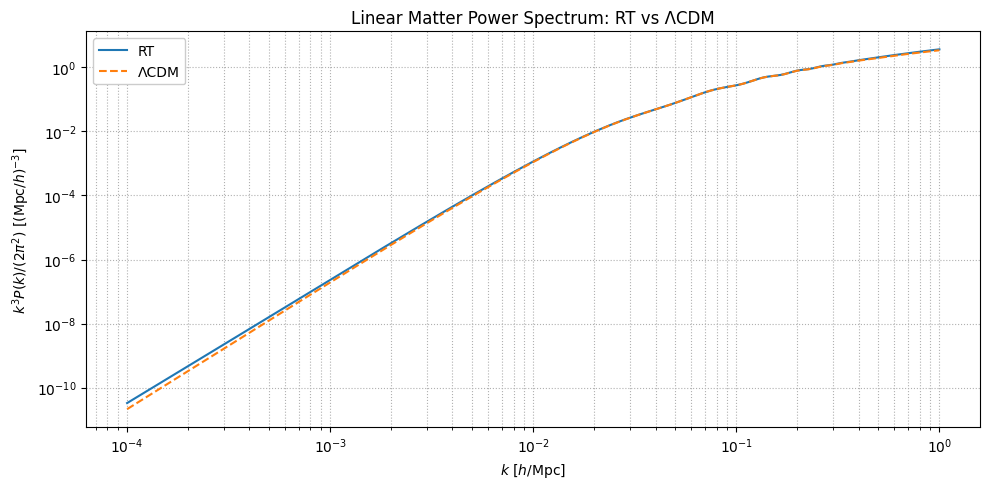

✅ Saved: images/matter_power_wide.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Ensure images directory
os.makedirs('images', exist_ok=True)

# Paths
data_dir  = 'data'
lcdm_file = os.path.join(data_dir, 'LCDM_Pk.dat')
rt_file   = os.path.join(data_dir, 'Rupture_Pk.dat')

# Load data
k_lcdm, pk_lcdm = np.loadtxt(lcdm_file, comments='#', usecols=(0,1), unpack=True)
k_rt,   pk_rt   = np.loadtxt(rt_file,   comments='#', usecols=(0,1), unpack=True)

# Dimensionless power Δ²(k)
dim_lcdm = k_lcdm**3 * pk_lcdm / (2 * np.pi**2)
dim_rt   = k_rt  **3 * pk_rt   / (2 * np.pi**2)

# Plot
plt.figure(figsize=(10,5))
plt.loglog(k_rt,   dim_rt,   'C0-',  label='RT')       # blue solid
plt.loglog(k_lcdm, dim_lcdm, 'C1--', label='ΛCDM')     # orange dashed

plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$k^3P(k)/(2\pi^2)\ [(\mathrm{Mpc}/h)^{-3}]$')
plt.title('Linear Matter Power Spectrum: RT vs ΛCDM')
plt.grid(True, which='both', linestyle=':', linewidth=0.8)

# Legend with RT first, upper left
plt.legend(framealpha=1, facecolor='white', loc='upper left')

plt.tight_layout()

# Save
outpath = 'images/matter_power_wide.png'
plt.savefig(outpath, dpi=300)
plt.show()

print(f"✅ Saved: {outpath}")


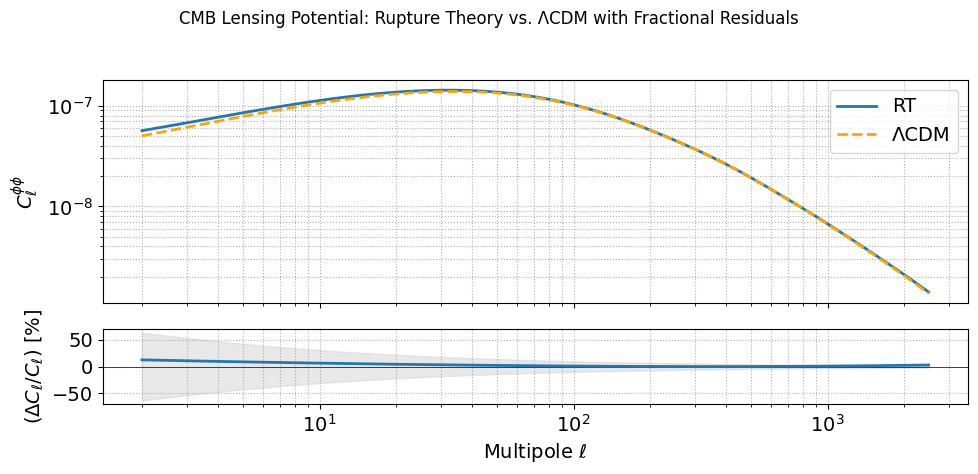

✅ Saved: images/lensing_residual_wide.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Ensure images directory exists
os.makedirs('images', exist_ok=True)

# Your data directory
data_dir = 'data'

# Load lensing potential from data/
ells, cl_lcdm = np.loadtxt(f'{data_dir}/LCDM_Clpp.dat',    comments='#', usecols=(0,1), unpack=True)
_,    cl_rt   = np.loadtxt(f'{data_dir}/Rupture_Clpp.dat', comments='#', usecols=(0,1), unpack=True)

# Trim low multipoles where Cℓ≈0
mask = cl_lcdm > 1e-12
ells, cl_lcdm, cl_rt = ells[mask], cl_lcdm[mask], cl_rt[mask]

# Fractional difference and cosmic‐variance envelope
frac = (cl_rt - cl_lcdm) / cl_lcdm
cv   = np.sqrt(2 / (2*ells + 1))

# Two‐panel figure with suptitle, wide format
fig, (ax1, ax2) = plt.subplots(
    2, 1, sharex=True,
    figsize=(10, 5),                    # <-- wide 10"x5" figure
    gridspec_kw={'height_ratios': [3, 1]}
)
fig.suptitle('CMB Lensing Potential: Rupture Theory vs. ΛCDM with Fractional Residuals', fontsize=12, y=0.95)

# Top: absolute spectra (ΛCDM dashed orange, RT solid blue)
ax1.loglog(ells, cl_rt,   '-',  color='C0',     label='RT')
ax1.loglog(ells, cl_lcdm, '--', color='orange', label='ΛCDM')
ax1.set_ylabel(r'$C_\ell^{\phi\phi}$')
ax1.legend(loc='upper right')
ax1.grid(True, which='both', linestyle=':')

# Bottom: percent residual with CV shading
ax2.axhline(0, color='k', linewidth=0.5)
ax2.plot(ells, 100*frac, color='C0')
ax2.fill_between(ells, -100*cv, 100*cv, color='lightgray', alpha=0.5)
ax2.set_xscale('log')
ax2.set_xlabel(r'Multipole $\ell$')
ax2.set_ylabel(r'$(\Delta C_\ell/C_\ell)\ [\%]$')
ax2.grid(True, which='both', linestyle=':')

plt.tight_layout(rect=[0, 0, 1, 0.93])
outpath = 'images/lensing_residual_wide.png'
plt.savefig(outpath, dpi=300)
plt.show()

print(f"✅ Saved: {outpath}")


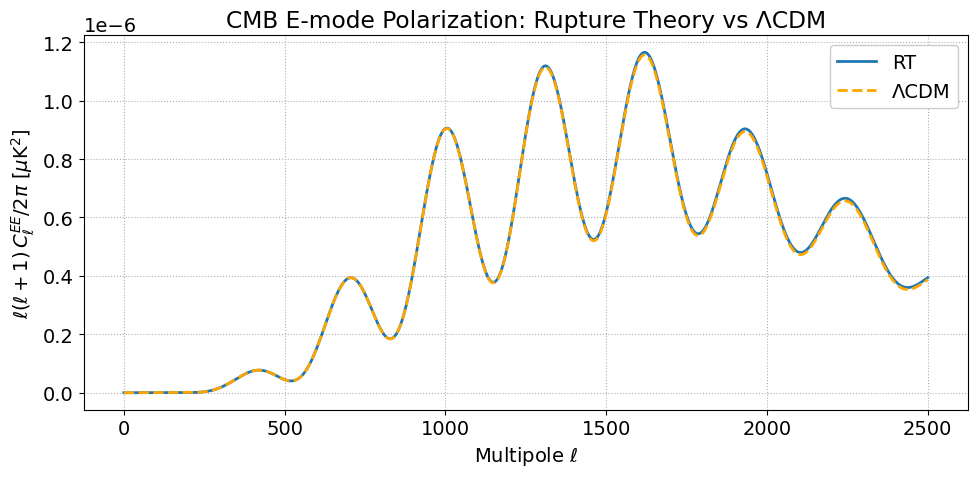

✅ Saved: images/rupture_vs_lcdm_ee_wide.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# 1) Ensure output folder exists
os.makedirs('images', exist_ok=True)

# 2) Paths into your data directory
data_dir  = 'data'
lcdm_file = os.path.join(data_dir, 'LCDM_EE.dat')
rt_file   = os.path.join(data_dir, 'Rupture_CAMB_EE.dat')

# 3) Load ℓ, C_ℓ from both datasets
ells, ee_lcdm = np.loadtxt(lcdm_file, comments='#', usecols=(0,1), unpack=True)
_,    ee_rt    = np.loadtxt(rt_file,   comments='#', usecols=(0,1), unpack=True)

# 4) Convert to ℓ(ℓ+1)Cℓ/2π units
factor       = ells * (ells + 1) / (2 * np.pi)
ee_lcdm_plot = factor * ee_lcdm
ee_rt_plot   = factor * ee_rt

# 5) Plot overlay, 10"x5" for spacious legend
plt.figure(figsize=(10,5))
plt.plot(ells, ee_rt_plot,   color='C0', label='RT')
plt.plot(ells, ee_lcdm_plot, '--', color='orange',  label='ΛCDM')
plt.xlabel(r'Multipole $\ell$')
plt.ylabel(r'$\ell(\ell+1)\,C_\ell^{EE}/2\pi\ [\mu\mathrm{K}^2]$')
plt.title('CMB E-mode Polarization: Rupture Theory vs ΛCDM')
plt.grid(True, linestyle=':', linewidth=0.8)
plt.legend(framealpha=1, facecolor='white', loc='upper right')
plt.tight_layout()

# 6) Save
outpath = 'images/rupture_vs_lcdm_ee_wide.png'
plt.savefig(outpath, dpi=300)
plt.show()

print(f"✅ Saved: {outpath}")


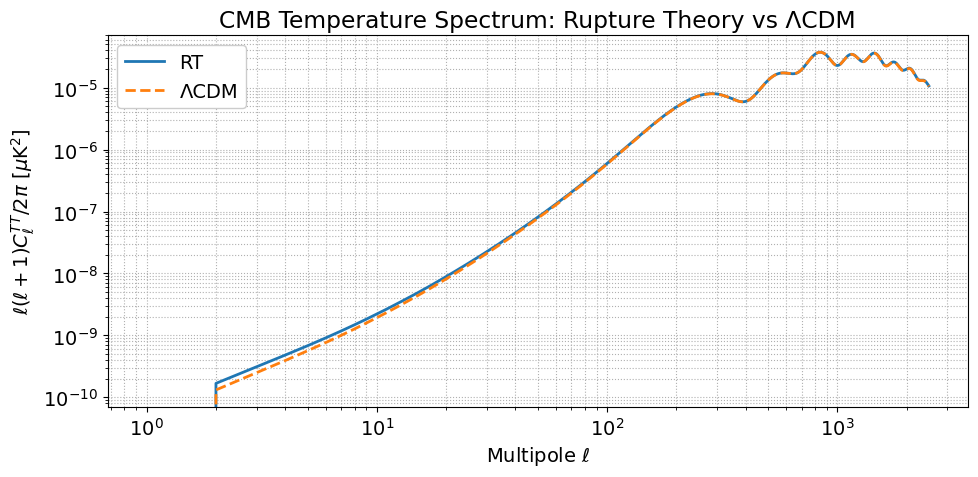

✅ Saved: images/temperature_power_wide_formatted.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Ensure images directory exists
os.makedirs('images', exist_ok=True)

# Load CMB TT spectra from data/
data_dir = 'data'
ells, tt_lcdm = np.loadtxt(f'{data_dir}/LCDM_TT.dat',    comments='#', usecols=(0,1), unpack=True)
_,    tt_rt   = np.loadtxt(f'{data_dir}/Rupture_TT.dat', comments='#', usecols=(0,1), unpack=True)

# Convert to ℓ(ℓ+1)Cℓ/2π units
factor       = ells * (ells + 1) / (2 * np.pi)
tt_lcdm_plot = factor * tt_lcdm
tt_rt_plot   = factor * tt_rt

# Plot with consistent styling: 10"x5", RT blue solid, LCDM orange dashed
plt.figure(figsize=(10,5))
plt.loglog(ells, tt_rt_plot,   'C0-',  label='RT')
plt.loglog(ells, tt_lcdm_plot, 'C1--', label='ΛCDM')

# Labels, title, grid
plt.xlabel(r'Multipole $\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell^{TT}/2\pi\ [\mu\mathrm{K}^2]$')
plt.title('CMB Temperature Spectrum: Rupture Theory vs ΛCDM')
plt.grid(True, which='both', linestyle=':', linewidth=0.8)

# Legend upper left, RT first
plt.legend(framealpha=1, facecolor='white', loc='upper left')

plt.tight_layout()

# Save figure
outpath = 'images/temperature_power_wide_formatted.png'
plt.savefig(outpath, dpi=300)
plt.show()

print(f"✅ Saved: {outpath}")


/tmp/ipython-input-88-453418938.py:16: RuntimeWarning: invalid value encountered in divide
  delta = (tt_rt - tt_lcdm) / tt_lcdm


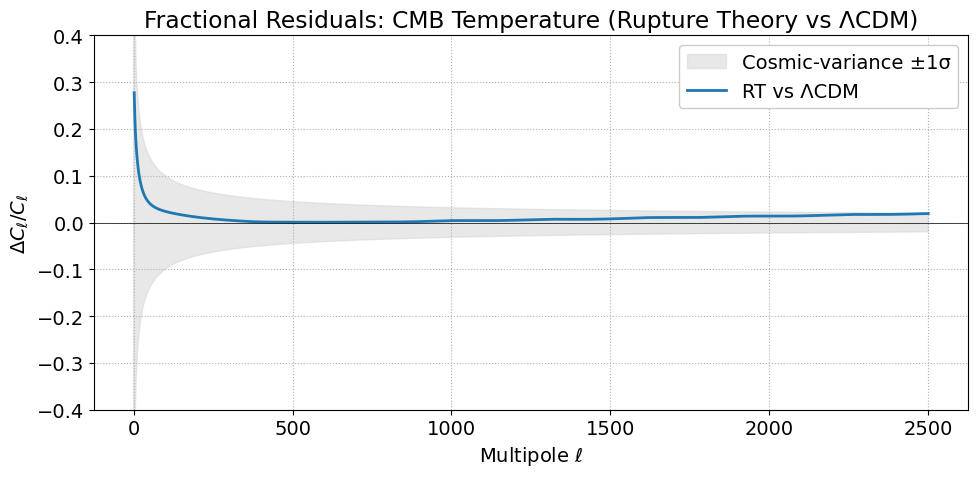

✅ Saved plot to images/tt_fractional_residual_limited04.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# 1) Ensure images folder exists
os.makedirs('images', exist_ok=True)

# 2) Data directory path
data_dir = '/content/data'

# 3) Load spectra
ells, tt_lcdm = np.loadtxt(f'{data_dir}/LCDM_TT.dat',    comments='#', usecols=(0,1), unpack=True)
_,    tt_rt   = np.loadtxt(f'{data_dir}/Rupture_TT.dat', comments='#', usecols=(0,1), unpack=True)

# 4) Compute fractional residuals and cosmic‐variance envelope
delta = (tt_rt - tt_lcdm) / tt_lcdm
cv    = np.sqrt(2 / (2*ells + 1))

# 5) Plot (10"x5")
plt.figure(figsize=(10,5))
plt.fill_between(ells, -cv, cv, color='lightgray', alpha=0.5, label='Cosmic-variance ±1σ')
plt.plot(ells, delta, 'C0-', label='RT vs ΛCDM')
plt.axhline(0, color='k', linewidth=0.5)

plt.xlabel(r'Multipole $\ell$')
plt.ylabel(r'$\Delta C_\ell/C_\ell$')
plt.title('Fractional Residuals: CMB Temperature (Rupture Theory vs ΛCDM)')
plt.legend(framealpha=1, facecolor='white', loc='upper right')
plt.grid(True, linestyle=':', linewidth=0.8)

# 6) Restrict y-axis to ±0.4
plt.ylim(-0.4, 0.4)

plt.tight_layout()

# 7) Save high‐res PNG
outpath = 'images/tt_fractional_residual_limited04.png'
plt.savefig(outpath, dpi=300)
plt.show()

print(f"✅ Saved plot to {outpath}")


/tmp/ipython-input-89-2742772009.py:21: RuntimeWarning: invalid value encountered in divide
  delta = (ee_rt - ee_lcdm) / ee_lcdm


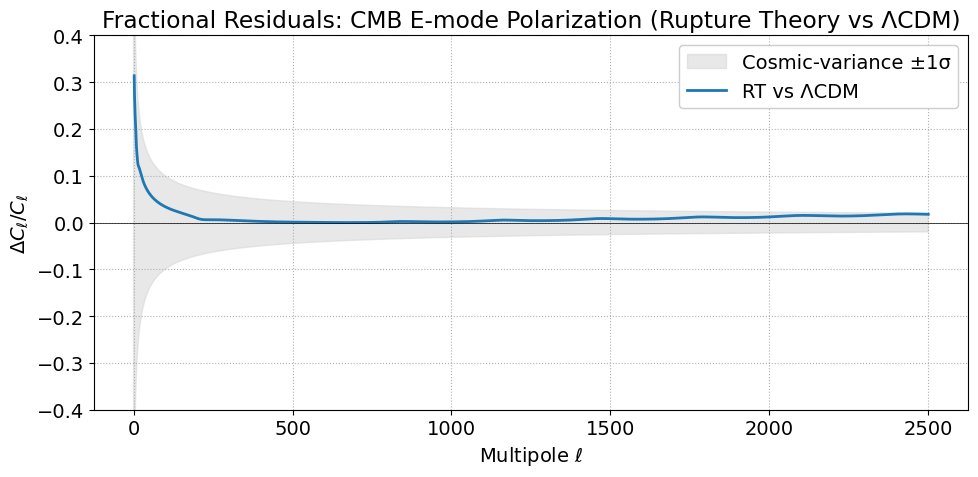

✅ Saved: images/ee_fractional_residual_wide_limited04.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Ensure images directory exists
os.makedirs('images', exist_ok=True)

# Loader that searches both 'data/' and current directory
def load_spectrum(fname):
    for d in ['data', '.']:
        path = f"{d}/{fname}" if d=='data' else fname
        if os.path.exists(path):
            return np.loadtxt(path, comments='#', usecols=(0,1), unpack=True)
    raise FileNotFoundError(f"{fname} not found in data/ or current directory")

# Load E-mode spectra
ells, ee_lcdm = load_spectrum('LCDM_EE.dat')
_,    ee_rt   = load_spectrum('Rupture_CAMB_EE.dat')

# Compute fractional residuals ΔC/C and cosmic-variance envelope
delta = (ee_rt - ee_lcdm) / ee_lcdm
cv    = np.sqrt(2 / (2*ells + 1))

# Plot (10"x5") with y-axis limited to ±0.4
plt.figure(figsize=(10,5))
plt.fill_between(ells, -cv, cv, color='lightgray', alpha=0.5, label='Cosmic-variance ±1σ')
plt.plot(ells, delta, 'C0-', label='RT vs ΛCDM')
plt.axhline(0, color='k', linewidth=0.5)

plt.xlabel(r'Multipole $\ell$')
plt.ylabel(r'$\Delta C_\ell/C_\ell$')
plt.title('Fractional Residuals: CMB E-mode Polarization (Rupture Theory vs ΛCDM)')
plt.legend(framealpha=1, facecolor='white', loc='upper right')
plt.grid(True, linestyle=':', linewidth=0.8)

plt.ylim(-0.4, 0.4)
plt.tight_layout()

# Save
outpath = 'images/ee_fractional_residual_wide_limited04.png'
plt.savefig(outpath, dpi=300)
plt.show()

print(f"✅ Saved: {outpath}")


/tmp/ipython-input-95-1636078162.py:17: RuntimeWarning: invalid value encountered in divide
  delta_all = (tt_rt_all - tt_lcdm_all) / tt_lcdm_all


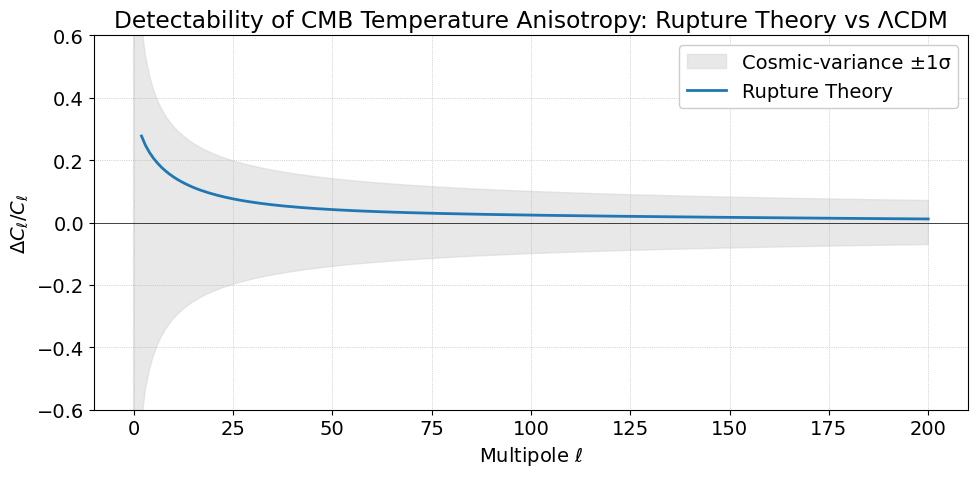

✅ Saved detectability plot to images/tt_detectability_cv_wide.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# 1) Ensure the output folder exists
os.makedirs('images', exist_ok=True)

# 2) Load your TT spectra from the data directory
data_dir   = 'data'
lcdm_file  = os.path.join(data_dir, 'LCDM_TT.dat')
rt_file    = os.path.join(data_dir, 'Rupture_TT.dat')

ells_all, tt_lcdm_all = np.loadtxt(lcdm_file, comments='#', usecols=(0,1), unpack=True)
_,         tt_rt_all   = np.loadtxt(rt_file,   comments='#', usecols=(0,1), unpack=True)

# 3) Compute fractional deviation and cosmic variance
delta_all = (tt_rt_all - tt_lcdm_all) / tt_lcdm_all
cv_all    = np.sqrt(2 / (2*ells_all + 1))

# 4) Restrict to ℓ ≤ 200
mask = ells_all <= 200
ells = ells_all[mask]
delta = delta_all[mask]
cv    = cv_all[mask]

# 5) Plot detectability, 10"x5"
plt.figure(figsize=(10,5))
plt.fill_between(ells, -cv, cv, color='lightgray', alpha=0.5, label='Cosmic-variance ±1σ')
plt.plot(ells, delta, 'C0-', label='Rupture Theory', linewidth=2)
plt.axhline(0, color='k', linewidth=0.5)

plt.xlabel(r'Multipole $\ell$')
plt.ylabel(r'$\Delta C_\ell/C_\ell$')
plt.title('Detectability of CMB Temperature Anisotropy: Rupture Theory vs ΛCDM')
plt.legend(framealpha=1, facecolor='white', loc='upper right')
plt.grid(True, linestyle=':', linewidth=0.5)

# 6) Clamp the vertical axis to ±0.6
plt.ylim(-0.6, 0.6)

plt.tight_layout()

# 7) Save the figure
outpath = 'images/tt_detectability_cv_wide.png'
plt.savefig(outpath, dpi=300)
plt.show()

print(f"✅ Saved detectability plot to {outpath}")


/tmp/ipython-input-94-2727662665.py:13: RuntimeWarning: invalid value encountered in divide
  delta_all = (ee_rt_all - ee_lcdm_all) / ee_lcdm_all


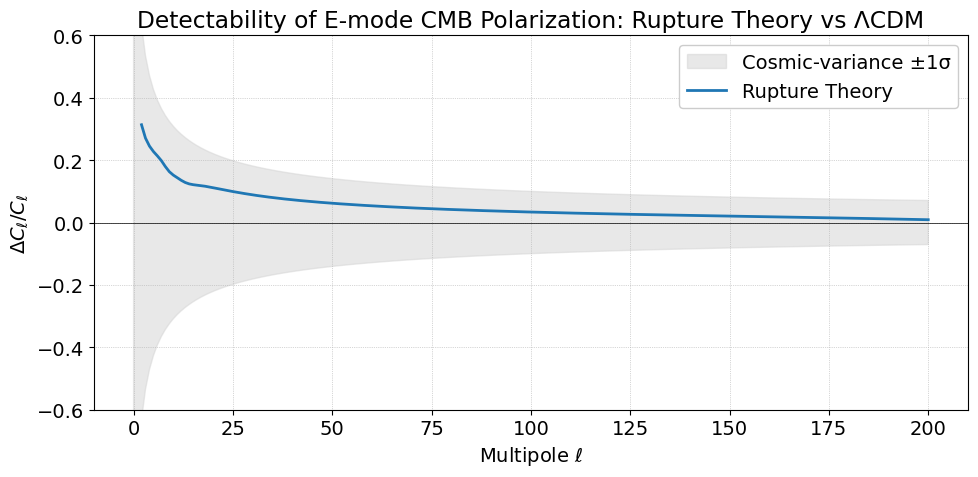

✅ Saved: images/ee_detectability_cv_wide.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# 1) Ensure images/ exists
os.makedirs('images', exist_ok=True)

# 2) Load EE spectra from data/
ells_all, ee_lcdm_all = np.loadtxt('data/LCDM_EE.dat',         comments='#', usecols=(0,1), unpack=True)
_,         ee_rt_all   = np.loadtxt('data/Rupture_CAMB_EE.dat', comments='#', usecols=(0,1), unpack=True)

# 3) Compute fractional deviation and cosmic-variance envelope
delta_all = (ee_rt_all - ee_lcdm_all) / ee_lcdm_all
cv_all    = np.sqrt(2 / (2*ells_all + 1))

# 4) Restrict to ℓ ≤ 200 for clarity
mask = ells_all <= 200
ells = ells_all[mask]
delta = delta_all[mask]
cv    = cv_all[mask]

# 5) Plot detectability (10"x5")
plt.figure(figsize=(10,5))
plt.fill_between(ells, -cv, cv, color='lightgray', alpha=0.5, label='Cosmic-variance ±1σ')
plt.plot(ells, delta, 'C0-', label='Rupture Theory', linewidth=2)
plt.axhline(0, color='k', linewidth=0.5)

plt.xlabel(r'Multipole $\ell$')
plt.ylabel(r'$\Delta C_\ell/C_\ell$')
plt.title('Detectability of E-mode CMB Polarization: Rupture Theory vs ΛCDM')
plt.legend(framealpha=1, facecolor='white', loc='upper right')
plt.grid(True, linestyle=':', linewidth=0.5)

# 6) Clamp the vertical axis to ±0.6
plt.ylim(-0.6, 0.6)

plt.tight_layout()

# 7) Save the figure
outpath = 'images/ee_detectability_cv_wide.png'
plt.savefig(outpath, dpi=300)
plt.show()

print(f"✅ Saved: {outpath}")
